<a href="https://colab.research.google.com/github/liyujiel/419project/blob/master/419Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPT419 Project

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
# TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']

## Base line

In [0]:
from keras.utils import multi_gpu_model

Using TensorFlow backend.


In [0]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

### cpu - gpu configuration

In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
keras.backend.set_session(sess)

In [0]:
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 128
epochs = 10

In [0]:
with open("/content/gdrive/My Drive/fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content) 

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


### initialize trainset and test set

In [0]:
x_train, y_train, x_test, y_test = [], [], [], []

In [0]:
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
        pixels = np.array(val, 'float32')

        emotion = keras.utils.to_categorical(emotion, num_classes)

        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)

    except:
    	print("",end="")

In [0]:
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28709 train samples
3589 test samples


### Baseline Net

In [0]:
def base_cnn_model(img_shape=(48, 48, 1), n_classes=7):
    #construct CNN structure
    model = Sequential()

    #1st convolution layer
    model.add(Conv2D(64, (5, 5), activation='relu', input_shape=img_shape))
    model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

    #2nd convolution layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    #3rd convolution layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

    model.add(Flatten())

    #fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(n_classes, activation='softmax'))
    
    return model

In [0]:
model = base_cnn_model()

### AlexNet

In [0]:
def alexnet_model(img_shape=(48, 48, 1), n_classes=7, l2_reg=0.1,
	weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [0]:
model = alexnet_model()

### ResNet50

In [0]:
from keras import applications

In [0]:
# model = keras.applications.resnet50.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=(48, 48, 1), pooling=None, classes=7)

### VGG19

In [0]:
def vgg19_model(img_shape=(48, 48, 1), n_classes=7, l2_reg=0.1,
	weights=None):

	# Initialize model
	vgg19 = Sequential()

	# Layer 1 & 2
	vgg19.add(Conv2D(64, (3, 3), padding='same',
		input_shape=img_shape, kernel_regularizer=l2(l2_reg)))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(64, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3 & 4
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(128, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(128, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 5, 6, 7, & 8
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(256, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 9, 10, 11, & 12
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 13, 14, 15, & 16
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(ZeroPadding2D((1, 1)))
	vgg19.add(Conv2D(512, (3, 3), padding='same'))
	vgg19.add(Activation('relu'))
	vgg19.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 17, 18, & 19
	vgg19.add(Flatten())
	vgg19.add(Dense(4096))
	vgg19.add(Activation('relu'))
	vgg19.add(Dropout(0.5))
	vgg19.add(Dense(4096))
	vgg19.add(Activation('relu'))
	vgg19.add(Dropout(0.5))
	vgg19.add(Dense(n_classes))
	vgg19.add(Activation('softmax'))

	if weights is not None:
		vgg19.load_weights(weights)

	return vgg19

In [0]:
# model = vgg19_model()

### VGG16

In [0]:
# model = keras.applications.vgg16.VGG16(include_top=True, weights=None, input_tensor=None, input_shape=(48,48,1), pooling=None, classes=7)

### Model init

In [0]:
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [0]:
filepath="/content/gdrive/My Drive/weights_base.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

In [0]:
model = keras.models.load_model("/content/gdrive/My Drive/alex_net_epoch25.h5") # 99% acc

### TPU model

In [0]:
# tf.keras.backend.clear_session()

In [0]:
# tpu_model = tf.contrib.tpu.keras_support.tpu_model(
#     model,
#     strategy=tf.contrib.tpu.TPUDistributionStrategy(
#         tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

### Train model

In [0]:
fit = False

if fit == True:
	#model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
	model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) #train for randomly selected one
else:
	model.load_weights('/content/gdrive/My Drive/alex_net_epoch25.h5') #load weights

In [0]:
#overall evaluation
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', 100*score[1])

3589/3589 [==============================] - 7s 2ms/step
Test loss: 1.299033981207919
Test accuracy: 61.96712176176658


In [0]:
score = model.predict(x_test)
y_classes = score.argmax(axis=-1)

In [0]:
y_classes

array([6, 6, 0, ..., 6, 0, 6])

In [0]:
model.save('/content/gdrive/My Drive/alexnet_epoch10_batch512.h5')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-293337b04445>", line 1, in <module>
    model.save('/content/gdrive/My Drive/alexnet_epoch10_batch512.h5')
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/network.py", line 1090, in save
    save_model(self, filepath, overwrite, include_optimizer)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py", line 382, in save_model
    _serialize_model(model, f, include_optimizer)
  File "/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py", line 114, in _serialize_model
    layer_group[name] = val
  File "/usr/local/lib/python3.6/dist-packages/keras/utils/io_utils.py", line 223, in __setitem__
    dataset[:] = val
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects

KeyboardInterrupt: ignored

In [0]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()


In [0]:
monitor_testset_results = False

if monitor_testset_results == True:
	#make predictions for test set
	predictions = model.predict(x_test)

	index = 0
	for i in predictions:
		if index < 30 and index >= 20:
			#print(i) #predicted scores
			#print(y_test[index]) #actual scores
			
			testing_img = np.array(x_test[index], 'float32')
			testing_img = testing_img.reshape([48, 48]);
			
			plt.gray()
			plt.imshow(testing_img)
			plt.show()
			
			print(i)
			
			emotion_analysis(i)
			print("----------------------------------------------")
		index = index + 1

### Test Picture

In [0]:
!wget https://nricafe.com/wp-content/uploads/2015/09/Happy-Indian.jpg

--2018-12-02 02:57:04--  https://nricafe.com/wp-content/uploads/2015/09/Happy-Indian.jpg
Resolving nricafe.com (nricafe.com)... 104.27.184.42, 104.27.185.42, 2606:4700:30::681b:b92a, ...
Connecting to nricafe.com (nricafe.com)|104.27.184.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69751 (68K) [image/jpeg]
Saving to: ‘Happy-Indian.jpg’

Happy-Indian.jpg    100%[===================>]  68.12K  --.-KB/s    in 0.008s  

2018-12-02 02:57:05 (8.30 MB/s) - ‘Happy-Indian.jpg’ saved [69751/69751]



/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image.py:492: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


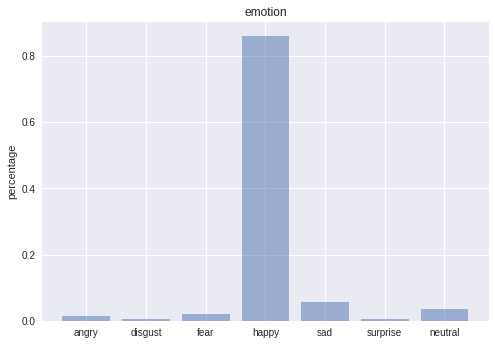

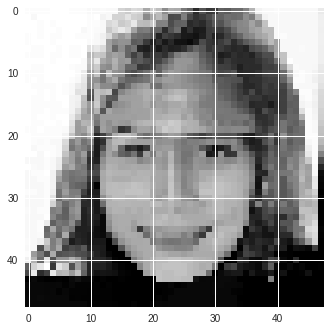

In [0]:
img = image.load_img("coco2.png", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()